In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime

from FIESTA_functions import *
from HARPS_N_functions import *
from NEID_solar_functions import *
from functions import *

In [2]:
from multiprocessing import Pool
import time
import math
from scipy import optimize
import scipy.optimize as opt

### Simplified optimisation (example)

CPU times: user 248 ms, sys: 0 ns, total: 248 ms
Wall time: 253 ms
[-0.30102957  0.95424249  1.00000298]


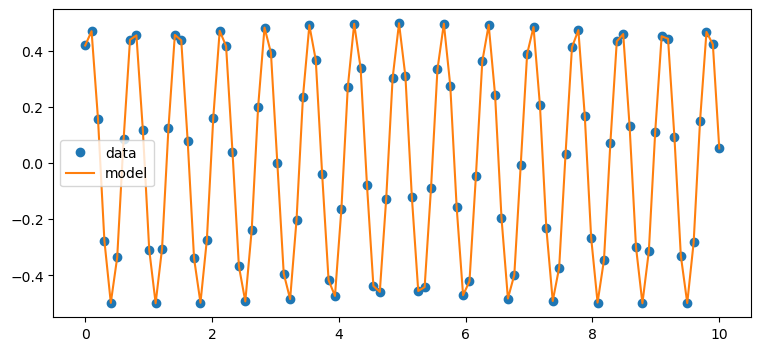

In [3]:
x_data = np.linspace(0,10,100)
y_data = 0.5*np.sin(x_data*9+1)

def model(params):
    y = 10**params[0]*np.sin(10**params[1]*x_data+params[2]) 
    return y

def loss(params):    
    diff = model(params) - y_data
    return np.sum(diff**2)

import scipy.optimize as opt
%time sol = opt.dual_annealing(loss, bounds=[[-1,1] for i in np.arange(2)] + [[0, np.pi]] )
print(sol.x)

fig = plt.figure(figsize=(9, 4))
plt.plot(x_data, y_data, 'o', label='data')
plt.plot(x_data, model(sol.x), label='model')
plt.legend()

# Data

In [4]:
#----------------------------------
# Read data
#----------------------------------
RV_FT_k     = np.loadtxt('../lib/FIESTA_daily_output/RV_FT_k.txt')
eRV_FT_k    = np.loadtxt('../lib/FIESTA_daily_output/eRV_FT_k.txt')
ΔRV_k       = np.loadtxt('../lib/FIESTA_daily_output/ΔRV_k.txt')
bjd_daily   = np.loadtxt('../lib/FIESTA_daily_output/bjd_daily.txt')
rv_daily    = np.loadtxt('../lib/FIESTA_daily_output/rv_daily.txt')
σrv_daily   = np.loadtxt('../lib/FIESTA_daily_output/σrv_daily.txt')
A_k         = np.loadtxt('../lib/FIESTA_daily_output/A_k.txt')

## Model 1 - $\Delta RV_k (A_k)$ 

In [5]:
# X = ΔRV_k.T
X = np.vstack((ΔRV_k[:5], A_k[:5])).T
Y = rv_daily - np.mean(rv_daily) 
W = 1/σrv_daily**2
X.shape, Y.shape

((202, 10), (202,))

In [6]:
X_dim = X.shape[1]
N = 10

# injected parameters 
amp = np.logspace(-1, 1, N)
t_inj = 0.5
phase_inj = 1

t = bjd_daily - min(bjd_daily)
w_array_1 = np.zeros((N, X_dim))
amp_pred_1 = np.zeros(N)
rms_array_1 = np.zeros(N)
phase_pred_1 = np.zeros(N)
t_pred_1 = np.zeros(N)

amp_pred_2 = np.zeros(N)
rms_array_2 = np.zeros(N)
phase_pred_2 = np.zeros(N)
t_pred_2 = np.zeros(N)

def wmse(y1, y2, w):
    wmse = np.average((y1-y2)**2, weights = w)
    return wmse

def model_1(params):
    planet_rv_model = 10**params[X_dim+1]*np.sin(10**params[X_dim+3]*t + params[X_dim+2]) 
    stellar_rv_model = np.sum(params[:X_dim]*X, axis=1) + params[X_dim]
    rv_model = planet_rv_model + stellar_rv_model
    return rv_model

def model_2(params):
    '''
        Keplerian model
    '''
    planet_rv_model = 10**params[0]*np.sin(10**params[2]*t + params[1]) 
    return planet_rv_model

def execute(i):
    y = Y + amp[i] *np.sin(t_inj*t+phase_inj)  
    
    def loss_1(params):
        return wmse(model_1(params), y, W)
    
    def loss_2(params):
        return wmse(model_2(params), y, W)    
    
    sol_1 = opt.dual_annealing(loss_1, bounds=[[-5,5] for i in np.arange(X_dim+1)] + [[-1.1,1.1], [0, np.pi], [np.log10(t_inj/1.5), np.log10(t_inj*1.5)]],  maxiter=1000)
    sol_2 = opt.dual_annealing(loss_2, bounds= [[-1.1,1.1], [0, np.pi], [np.log10(t_inj/1.5), np.log10(t_inj*1.5)]],  maxiter=1000)
    
    fitted_params_1 = sol_1.x
    fitted_params_2 = sol_2.x    

    w_array_1[i] = fitted_params_1[:X_dim]
    amp_pred_1[i] = 10**fitted_params_1[X_dim+1]
    phase_pred_1[i] = fitted_params_1[X_dim+2]
    t_pred_1[i] = 10**fitted_params_1[X_dim+3]
    rms_array_1[i] = loss_1(fitted_params_1)**0.5

    amp_pred_2[i] = 10**fitted_params_2[0]
    phase_pred_2[i] = fitted_params_2[1]
    t_pred_2[i] = 10**fitted_params_2[2]
    rms_array_2[i] = loss_2(fitted_params_2)**0.5
    
    return w_array_1[i], amp_pred_1[i], phase_pred_1[i], t_pred_1[i] , rms_array_1[i], amp_pred_2[i], phase_pred_2[i], t_pred_2[i], rms_array_2[i]

if __name__ == "__main__":
    # first way, using multiprocessing
    start_time = time.perf_counter()
    
    with Pool(processes=os.cpu_count()) as pool:
        result = pool.map(execute, range(0,N)) 
    
    finish_time = time.perf_counter()
    print("Program finished in {} seconds - using multiprocessing".format(finish_time-start_time))
    print("---")

for i in range(len(result)):
    w_array_1[i], amp_pred_1[i], phase_pred_1[i], t_pred_1[i] , rms_array_1[i], amp_pred_2[i], phase_pred_2[i], t_pred_2[i], rms_array_2[i] = result[i]
    
print('amp\n', amp)
print('amp_pred\n', amp_pred_1)
print('amp_pred\n', amp_pred_2)

Program finished in 4.348286586115137 seconds - using multiprocessing
---
amp
 [ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]
amp_pred
 [ 0.62726785  0.6473386   0.77130371  0.74226015  0.8459781   1.71563704
  2.55481318  3.97604818  6.36308013 10.35938712]
amp_pred
 [ 0.66679003  0.68706933  0.72140134  0.86898691  1.16382464  1.6649996
  2.51388599  3.94239214  6.33571329 10.33574469]


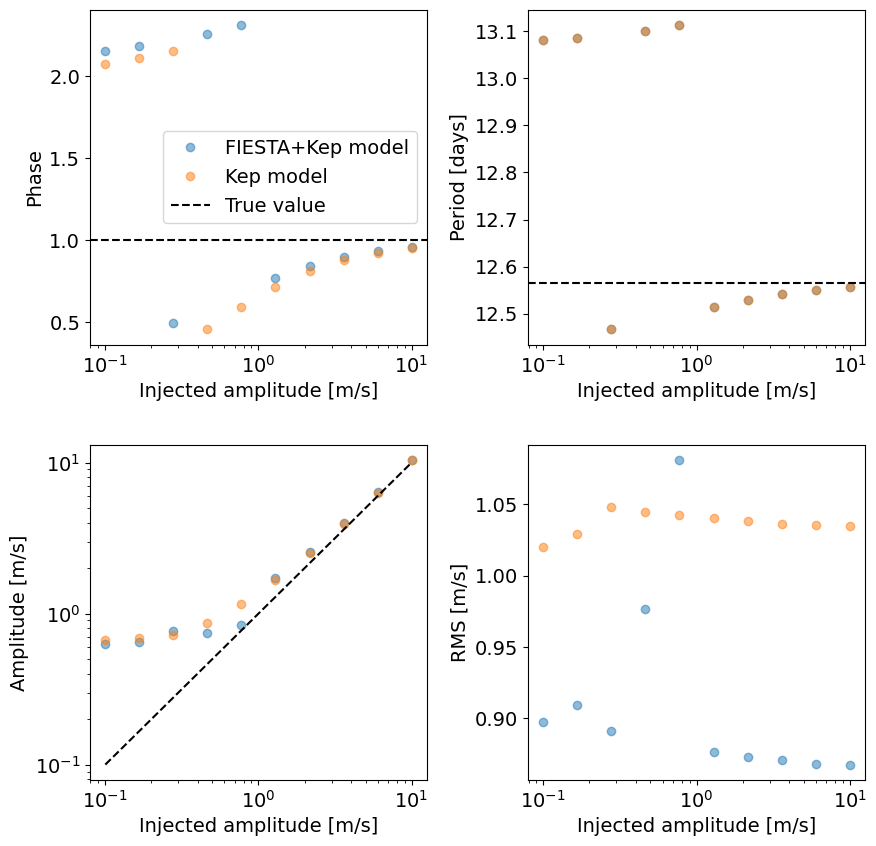

In [7]:
plt.rcParams['font.size'] = '14'

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

axs[0,0].plot(amp, phase_pred_1, 'o', alpha=0.5, label='FIESTA+Kep model')
axs[0,0].plot(amp, phase_pred_2, 'o', alpha=0.5, label='Kep model')
axs[0,0].set_xscale('log')
axs[0,0].axhline(y = phase_inj, color = 'k', linestyle = '--', label='True value')
axs[0,0].set_xlabel('Injected amplitude [m/s]')
axs[0,0].set_ylabel('Phase')
axs[0,0].legend()

axs[0,1].plot(amp, 2*np.pi/t_pred_1, 'o', alpha=0.5)
axs[0,1].plot(amp, 2*np.pi/t_pred_1, 'o', alpha=0.5)
axs[0,1].set_xscale('log')
axs[0,1].axhline(y = 2*np.pi/t_inj, color = 'k', linestyle = '--')
axs[0,1].set_xlabel('Injected amplitude [m/s]')
axs[0,1].set_ylabel('Period [days]')

axs[1,0].plot(amp, amp_pred_1, 'o', alpha=0.5)
axs[1,0].plot(amp, amp_pred_2, 'o', alpha=0.5)
axs[1,0].plot(amp, amp, 'k--')
axs[1,0].set_xlabel('Injected amplitude [m/s]')
axs[1,0].set_ylabel('Amplitude [m/s]')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')


axs[1,1].plot(amp, rms_array_1, 'o', alpha=0.5)
axs[1,1].plot(amp, rms_array_2, 'o', alpha=0.5)
axs[1,1].set_xlabel('Injected amplitude [m/s]')
axs[1,1].set_ylabel('RMS [m/s]')
axs[1,1].set_xscale('log')

plt.show()

## Model 2 - $RV_{FT,k}$ with injected planet

0.0304642522491393
0.029811805698080344


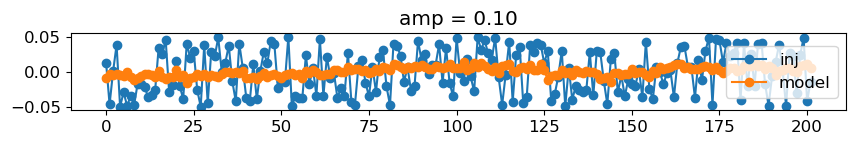

0.06204760836267144
0.05929076547352017


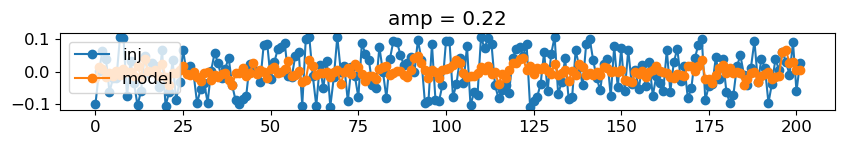

0.1259899903209979
0.12330836760912033


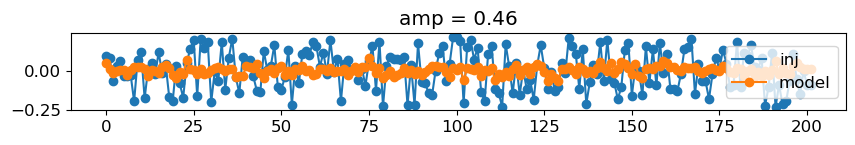

0.2891662044020403
0.27249651285662546


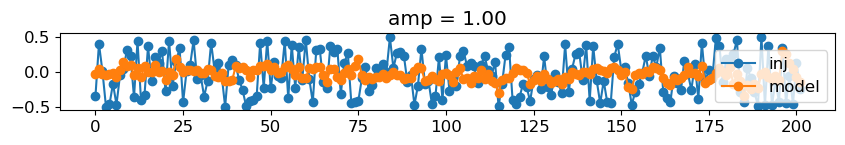

0.6081955036193469
0.48735563281887084


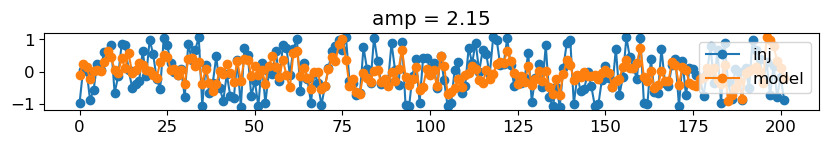

1.3129304266895665
0.7093658340820598


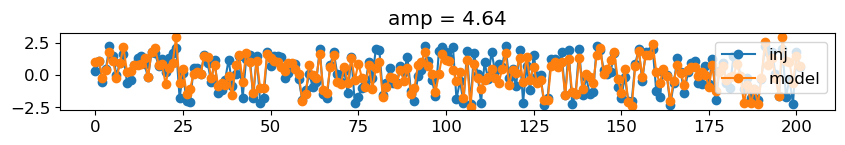

2.8185623664848776
0.8423776933092402


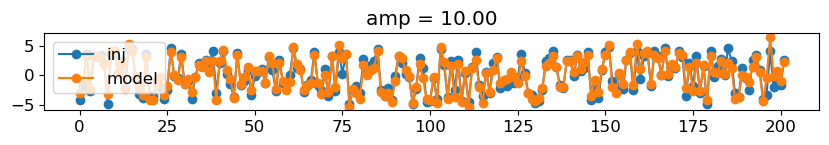

6.08819579613823
0.8819606107448433


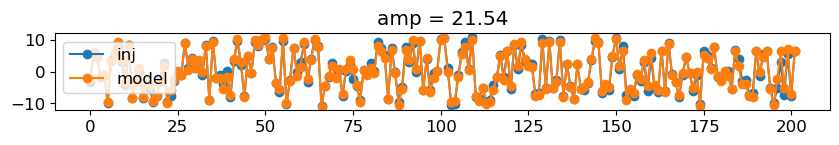

14.198980456446828
0.8891702720960836


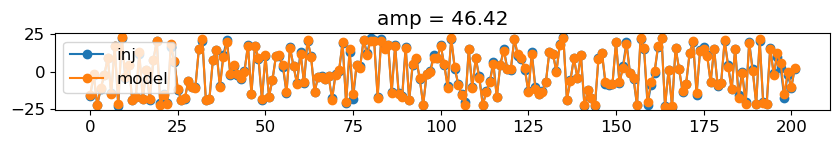

28.243817318034104
0.8884061720095094


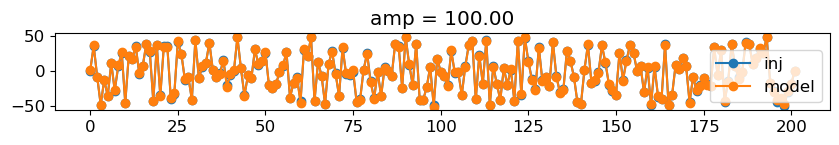

In [8]:
plt.rcParams['font.size'] = '12'

N = 10
rms_array_1 = np.zeros(N)
rms_array_2 = np.zeros(N)
amp = np.logspace(-1, 2, N)

for i in range(N):
    RV_inj = (np.random.random(202)-0.5)*amp[i]
    # X = (RV_FT_k[:5] + RV_inj).T
    X = np.vstack(((RV_FT_k[:5] + RV_inj), ΔRV_k[:5])).T
    # adding A_k[:5] or  rv_daily-np.mean(rv_daily)+RV_inj does not improve 
    Y = RV_inj
    W = 1/σrv_daily**2
    X.shape, Y.shape
    
    X_dim = X.shape[1]

    def wmse(y1, y2, w):
        wmse = np.average((y1-y2)**2, weights = w)
        return wmse

    def RV_inj_model(params): 
        return np.sum(params[:X_dim]*X, axis=1) + params[X_dim]

    def loss(params):
        return wmse(RV_inj_model(params), Y, W)**0.5

    sol = opt.dual_annealing(loss, bounds=[[-10,10] for i in np.arange(X_dim+1)],  maxiter=1000)

    fitted_params = sol.x
    
    rms_array_1[i] = wmse(RV_inj, np.zeros(202), W)**0.5
    print(rms_array_1[i])
    rms_array_2[i] = loss(fitted_params)
    print(rms_array_2[i])
    
    fig = plt.figure(figsize=(10, 1))
    plt.title('amp = %.2f'%amp[i])
    plt.plot(RV_inj, 'o-', label='inj')
    plt.plot(RV_inj_model(fitted_params), 'o-', label='model')
    plt.legend()
    plt.show()    
    

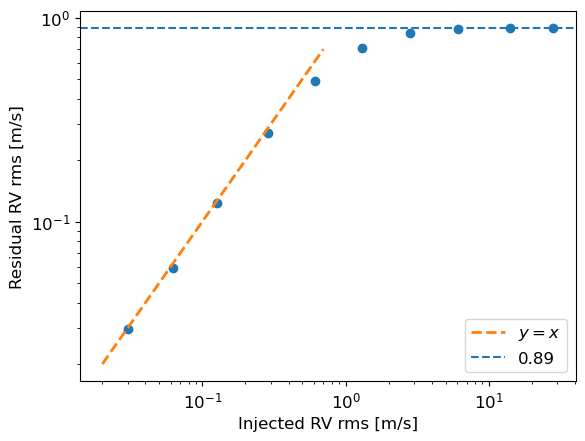

In [9]:
plt.plot(rms_array_1, rms_array_2, 'o')
plt.plot([0.02,0.7], [0.02,0.7], '--', lw=2, label='$y = x$')
plt.axhline(y=rms_array_2[-1], ls='--', label='%.2f' % rms_array_2[-1])
plt.xlabel('Injected RV rms [m/s]')
plt.ylabel('Residual RV rms [m/s]')
plt.xscale('log')
plt.yscale('log')
plt.legend()

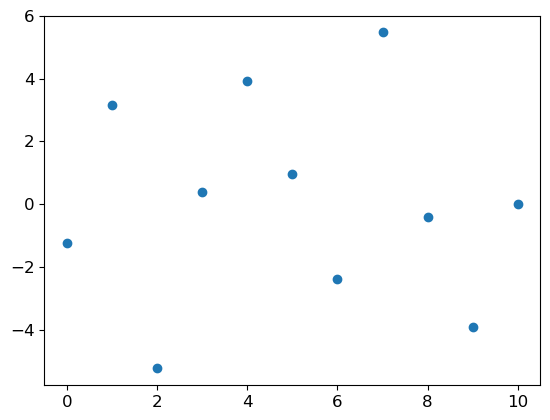

In [10]:
plt.plot(fitted_params, 'o')
# np.sum(fitted_params[:-1]), np.std(np.sum(fitted_params[:X_dim]*RV_FT_k[:5].T, axis=1) + fitted_params[X_dim])
# np.sum(fitted_params[:X_dim]*RV_FT_k[:6].T, axis=1) + fitted_params[X_dim]

0.02872503181479774
0.7854845857424338


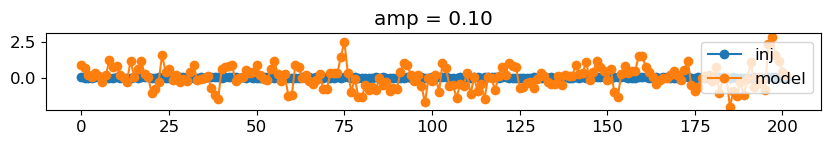

0.06614922658193298
0.7865313025749119


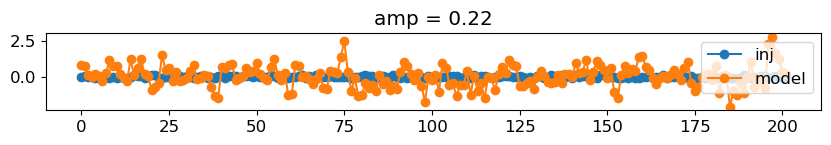

0.13716428449933712
0.7882602806216438


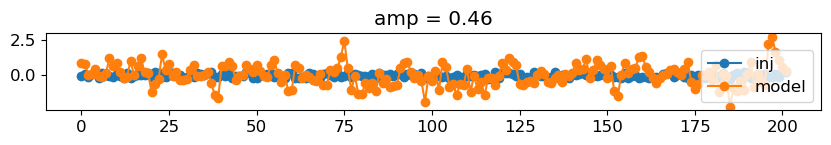

0.2942376730038286
0.7868084012266445


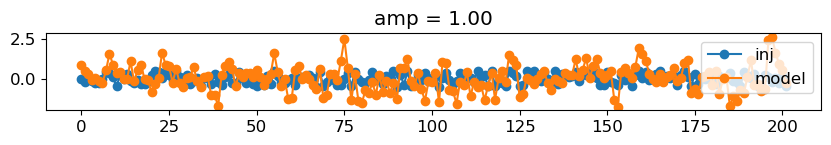

0.6204174480650599
0.8015025864759864


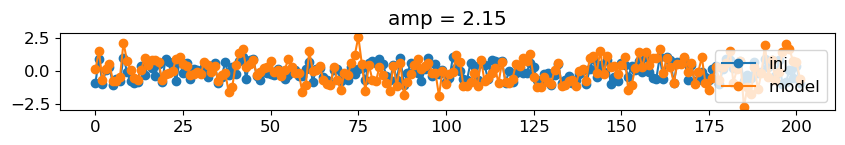

1.3074561534568956
0.8164858084215332


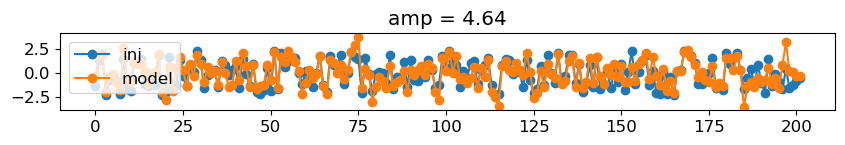

2.8800683231888744
0.8874921436798922


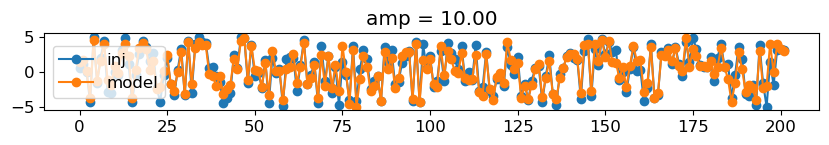

5.598549955379656
1.01685733337003


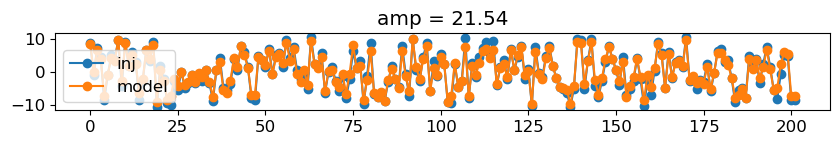

13.984791980891686
1.8458573093928055


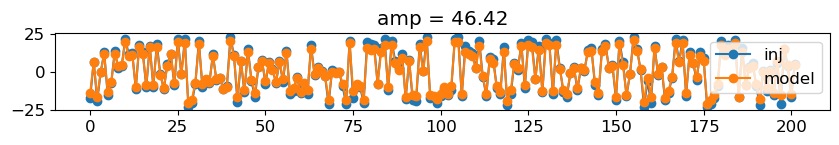

28.66446647411208
3.5790922835659704


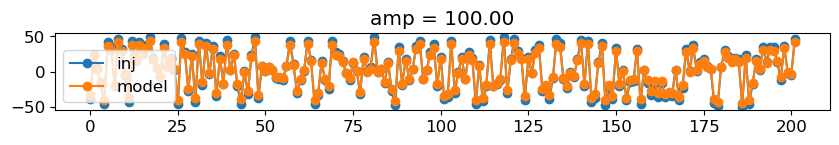

In [11]:
plt.rcParams['font.size'] = '12'

N = 10
rms_array_1 = np.zeros(N)
rms_array_2 = np.zeros(N)
amp = np.logspace(-1, 2, N)

RV_inj = (np.random.random(202)-0.5)*10
# X = (RV_FT_k[:5] + RV_inj).T
X = np.vstack(((RV_FT_k[:5] + RV_inj), ΔRV_k[:5])).T
# adding A_k[:5] or  rv_daily-np.mean(rv_daily)+RV_inj does not improve 
Y = RV_inj
W = 1/σrv_daily**2
X.shape, Y.shape

X_dim = X.shape[1]

def wmse(y1, y2, w):
    wmse = np.average((y1-y2)**2, weights = w)
    return wmse

def RV_inj_model(params): 
    return np.sum(params[:X_dim]*X, axis=1) + params[X_dim]

def loss(params):
    return wmse(RV_inj_model(params), Y, W)**0.5

sol = opt.dual_annealing(loss, bounds=[[-10,10] for i in np.arange(X_dim+1)],  maxiter=1000)

fitted_params = sol.x

for i in range(N):
    RV_inj_test = (np.random.random(202)-0.5)*amp[i]
    rms_array_1[i] = wmse(RV_inj_test, np.zeros(202), W)**0.5
    print(rms_array_1[i])
    X = np.vstack(((RV_FT_k[:5] + RV_inj_test), ΔRV_k[:5])).T
    Y = RV_inj_test
    rms_array_2[i] = loss(fitted_params)
    print(rms_array_2[i])
    
    fig = plt.figure(figsize=(10, 1))
    plt.title('amp = %.2f'%amp[i])
    plt.plot(RV_inj_test, 'o-', label='inj')
    plt.plot(RV_inj_model(fitted_params), 'o-', label='model')
    plt.legend()
    plt.show()    
    

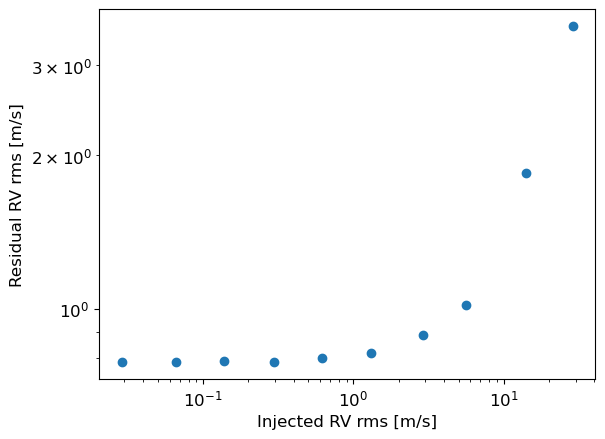

In [12]:
plt.plot(rms_array_1, rms_array_2, 'o')
# plt.plot([0.02,0.7], [0.02,0.7], '--', lw=2, label='$y = x$')
# plt.axhline(y=rms_array_2[-1], ls='--', label='%.2f' % rms_array_2[-1])
plt.xlabel('Injected RV rms [m/s]')
plt.ylabel('Residual RV rms [m/s]')
plt.xscale('log')
plt.yscale('log')
# plt.legend()

In [13]:
# X.shape, RV_FT_k[:5].shape, np.sum(fitted_params[:X_dim]*RV_FT_k[:5].T, axis=1).shape, fitted_params[X_dim]

# Model 2.2

In [14]:
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle

# print(tf.VERSION)
print(tf.keras.__version__)

2023-03-26 17:37:36.027806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 17:37:36.457226: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-26 17:37:40.914308: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/a

2.10.0


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# def model_MLP(X, Y, bjd, σrv, lr_model, epochs=200, learning_rate=2e-4, kk=1):
def model_MLP(X, Y, bjd, σrv, lr_model, epochs=200, learning_rate=2e-4):

    if 0:   
        scaler = StandardScaler()
        scaler.fit_transform(X)
    
    x_train, x_test, y_train, y_test, t_train, t_test, σrv_train, σrv_test = train_test_split(X, Y, bjd, σrv, test_size=0.3, random_state=32)    
    batch_size= x_train.shape[0]
    adam = Adam(learning_rate=learning_rate)

    def custom_mse(y_test, y_pred):
        squared_difference = tf.dtypes.cast(tf.square((y_test - y_pred)/σrv_test), tf.float64) 
        return tf.dtypes.cast(tf.math.reduce_sum(squared_difference)/tf.math.reduce_sum(tf.square(1/σrv_test)), tf.float64)  

    # compile the model
    lr_model.compile(loss=custom_mse,
                  optimizer=adam,
                  metrics=[custom_mse])

    ### Fit the model
    lr_model_history = lr_model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        # callbacks = [callback],
                        validation_data=(x_test, y_test))
    
    y_pred = lr_model.predict(x_test)

    
    plt.subplots(figsize=(12, 4))
    plt.subplots_adjust(wspace=0.3)

    ax1 = plt.subplot(131)
    ax1.plot(np.sqrt(lr_model_history.history['loss']), 'b', label='train')    
    ax1.plot(np.sqrt(lr_model_history.history['val_loss']), 'r' ,label='test')
    ax1.set_xlabel(r'Epoch')
    ax1.set_ylabel(r'wmse')
    ax1.set_yscale('log')
    ax1.legend()
    # ax1.tick_params(labelsize=20)
    ax1.grid()

    ax2 = plt.subplot(132)
    ax2.plot(t_test, y_test, 'r.', label='test')
    ax2.plot(t_test, y_pred, 'k.', label='pred')
    ax2.set_ylabel('RV [m/s]')
    ax2.legend()

    ax3 = plt.subplot(133)
    ax3.plot(y_test, y_pred, 'b.')
    ax3.set_xlabel('test [m/s]')
    ax3.set_ylabel('pred [m/s]')
    ax3.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--')
    plt.show()    

    ave, std = weighted_avg_and_std(y_pred[:,0]-y_test, 1/σrv_test**2)
    print(std)
    
    return lr_model, y_test, y_pred[:,0], σrv_test, t_test, std
    

In [16]:
RV_inj = (np.random.random(202)-0.5)*10
np.std(RV_inj)

2.879459347946103

2/2 [==============================] - 0s 2ms/step


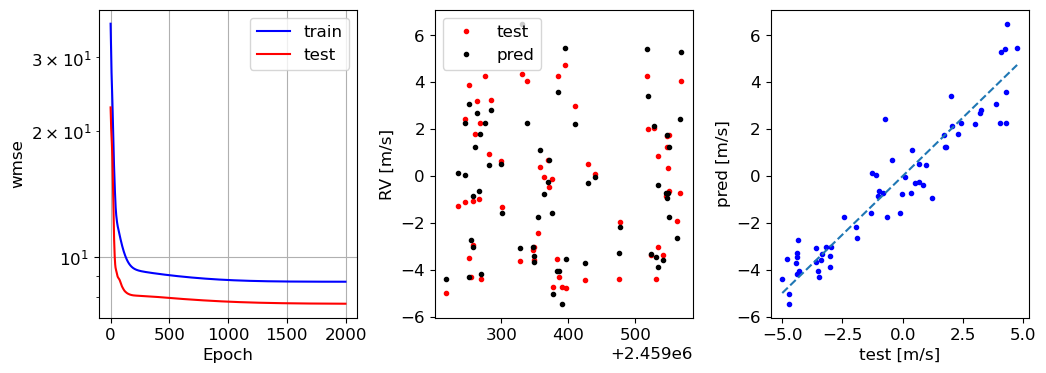

0.9745529308570727
2/2 [==============================] - 0s 2ms/step


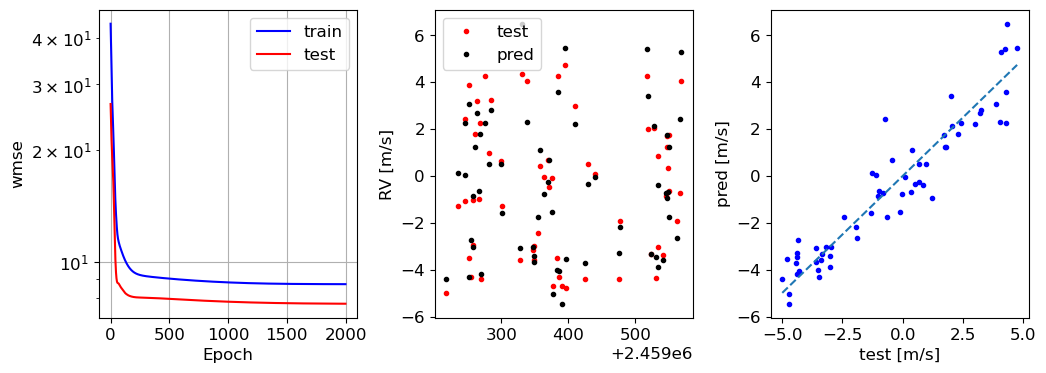

0.9747056204907562


In [17]:
# Add ramdom RV shift 
run = 2
weights = np.zeros((run, X.shape[0]))
for i in range(run):
    
    X = (RV_FT_k[:5] + RV_inj).T
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()
    

2/2 [==============================] - 0s 2ms/step


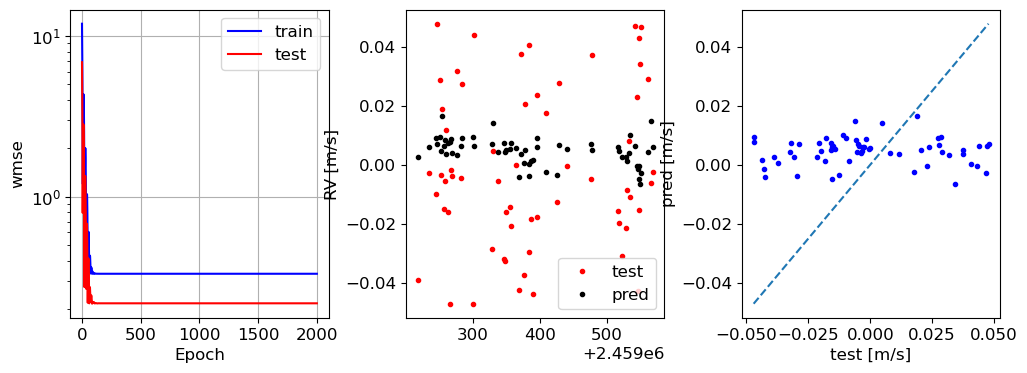

0.026949544729779062
2/2 [==============================] - 0s 1ms/step


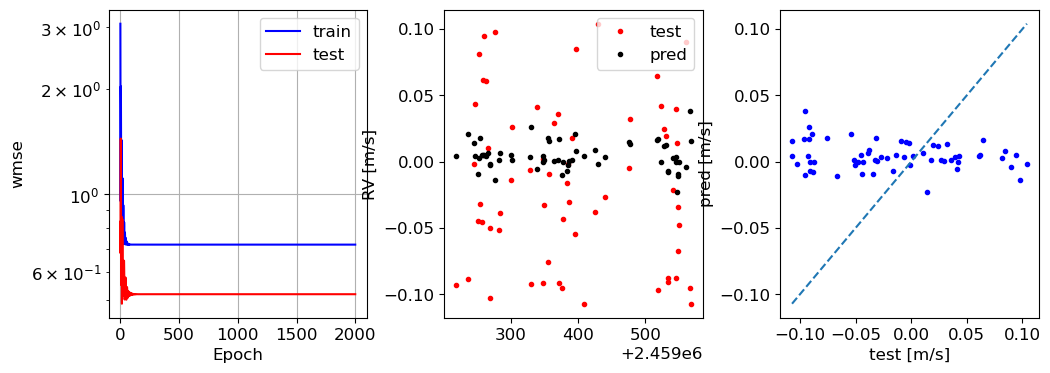

0.06408024361798884


2/2 [==============================] - 0s 1ms/step


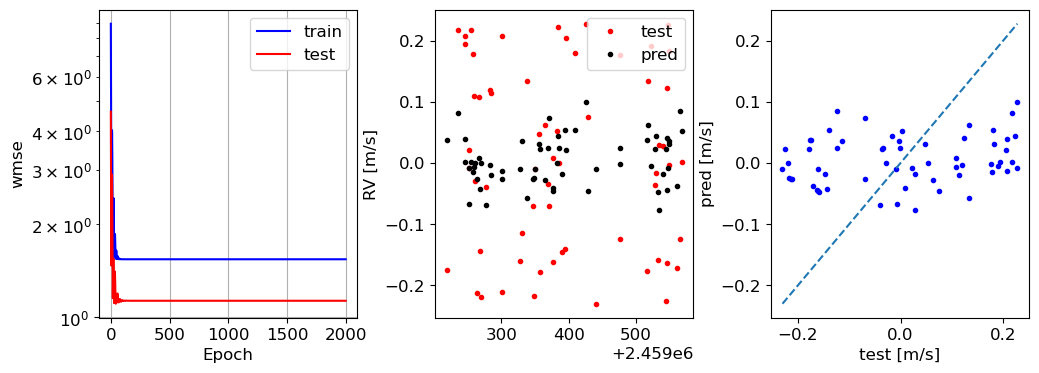

0.14324219717988326


2/2 [==============================] - 0s 1ms/step


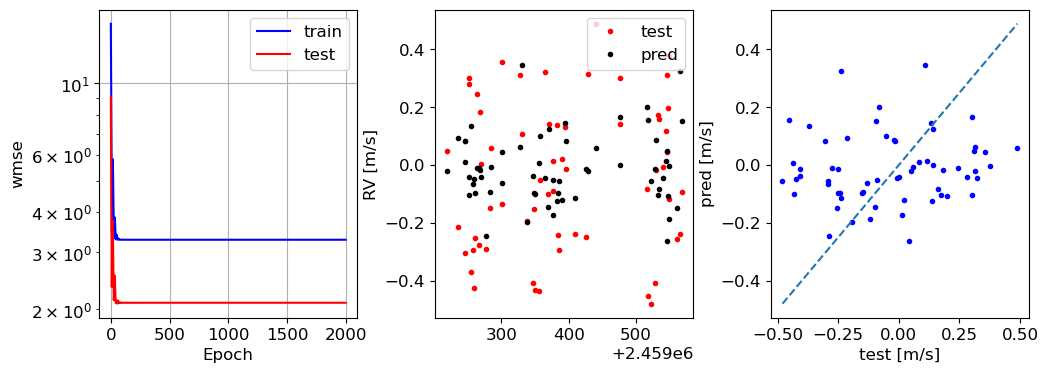

0.2699017724493184
2/2 [==============================] - 0s 2ms/step


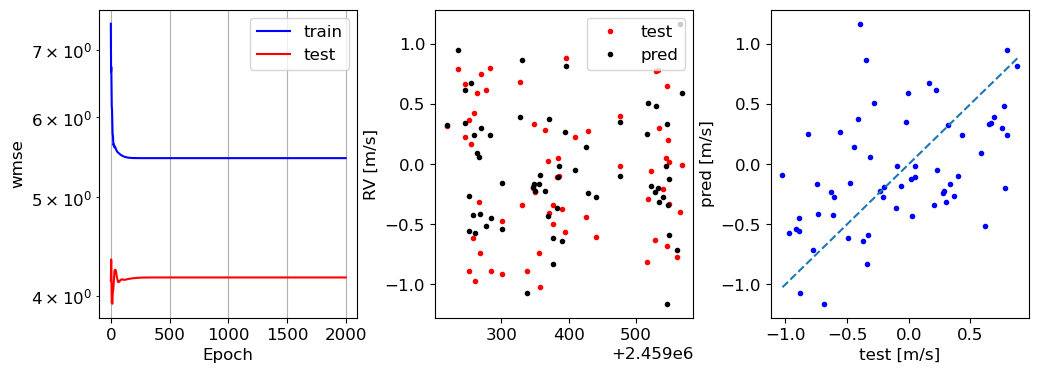

0.5235278137909467
2/2 [==============================] - 0s 2ms/step


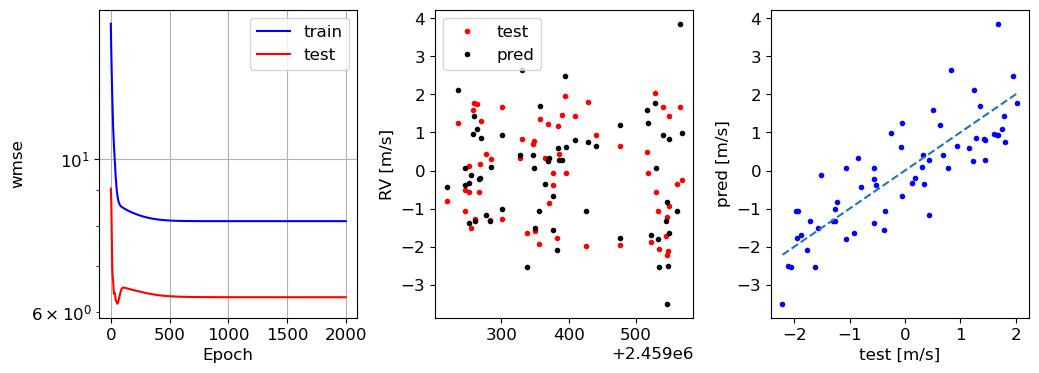

0.7915519634827438
2/2 [==============================] - 0s 2ms/step


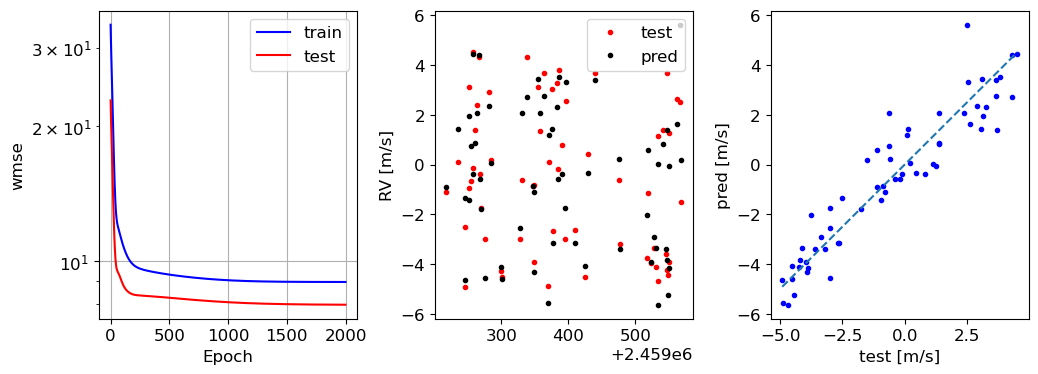

1.013636997607343
2/2 [==============================] - 0s 2ms/step


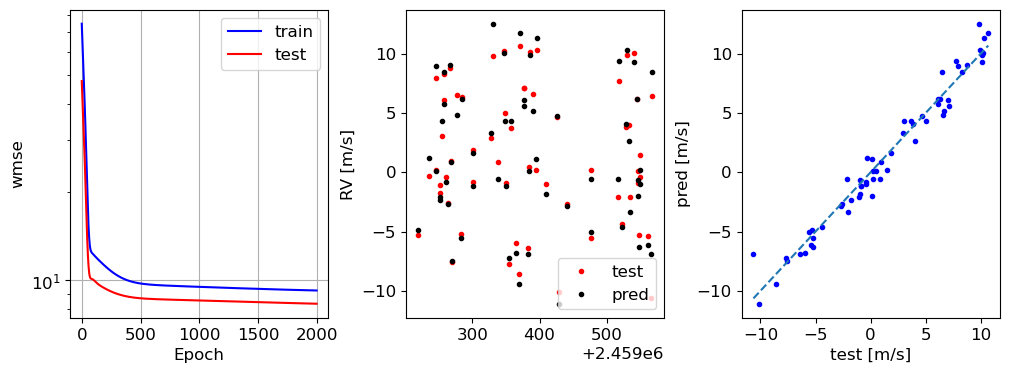

1.0290212795164222
2/2 [==============================] - 0s 1ms/step


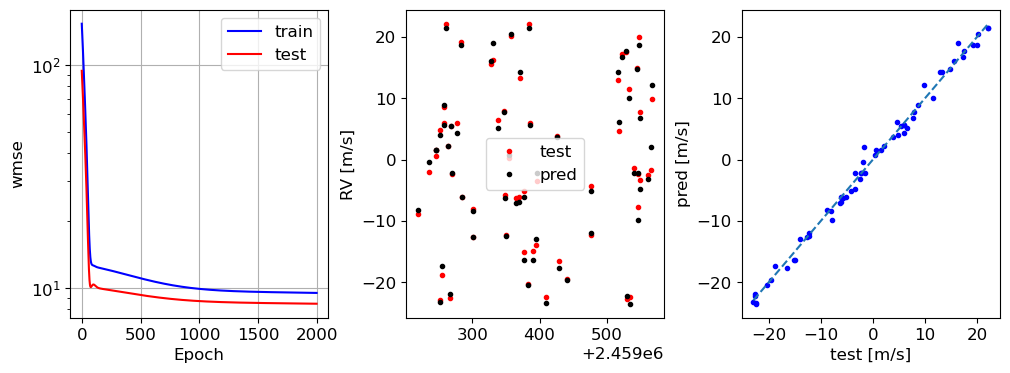

1.0411734875925347
2/2 [==============================] - 0s 1ms/step


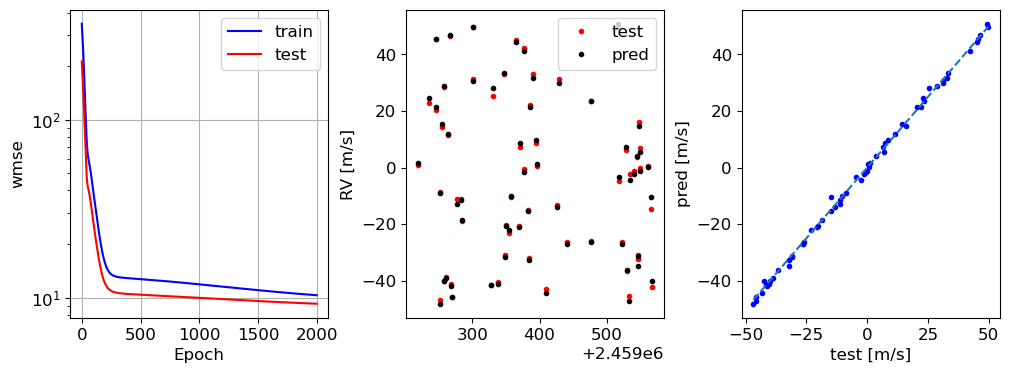

1.1254586662446153


In [18]:
# Add ramdom RV shift 
N = 10
rms_array_1 = np.zeros(N)
rms_array_2 = np.zeros(N)

for i in range(N):
    
    RV_inj = (np.random.random(202)-0.5)*amp[i]
    X = (RV_FT_k[:5] + RV_inj).T
    # X = np.vstack(((RV_FT_k[:5] + RV_inj), ΔRV_k[:5])).T
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    
    rms_array_1[i] = wmse(RV_inj, np.zeros(202), W)**0.5
    rms_array_2[i] = std
    

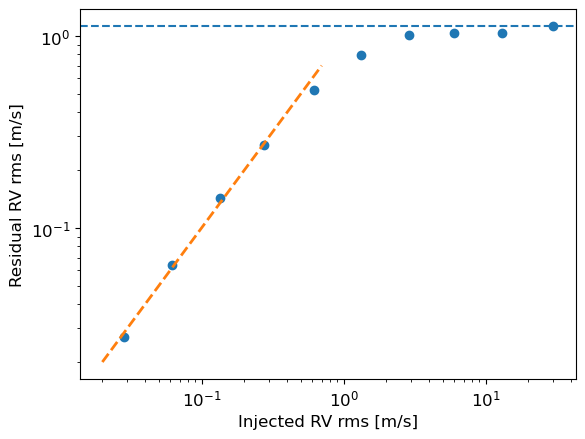

In [19]:
plt.plot(rms_array_1, rms_array_2, 'o')
plt.plot([0.02,0.7], [0.02,0.7], '--', lw=2, label='$y = x$')
plt.axhline(y=rms_array_2[-1], ls='--', label='%.2f' % rms_array_2[-1])
plt.xlabel('Injected RV rms [m/s]')
plt.ylabel('Residual RV rms [m/s]')
plt.xscale('log')
plt.yscale('log')
# plt.legend()

2/2 [==============================] - 0s 2ms/step


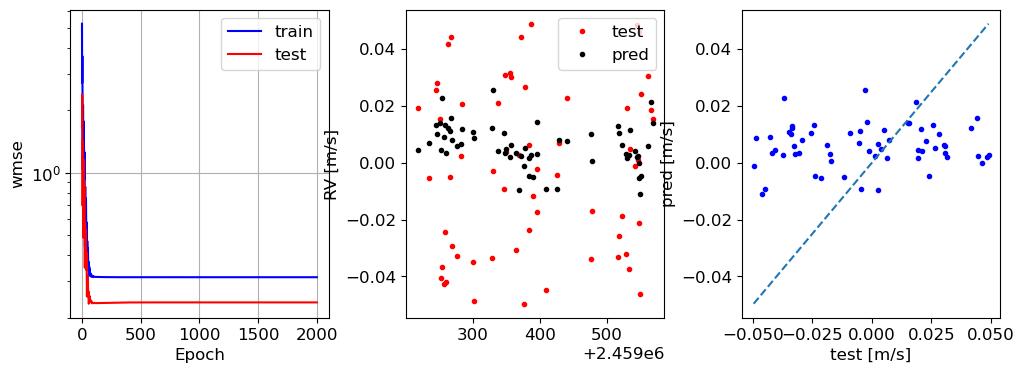

0.031089910672672083
2/2 [==============================] - 0s 1ms/step


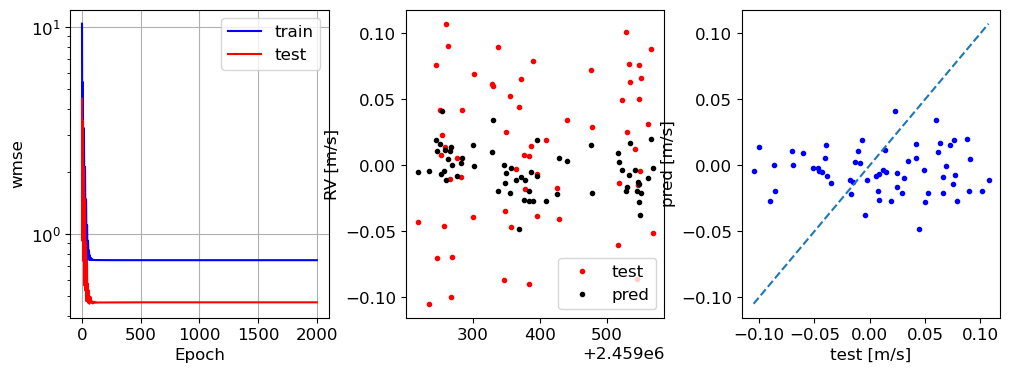

0.058031878192186116
2/2 [==============================] - 0s 1ms/step


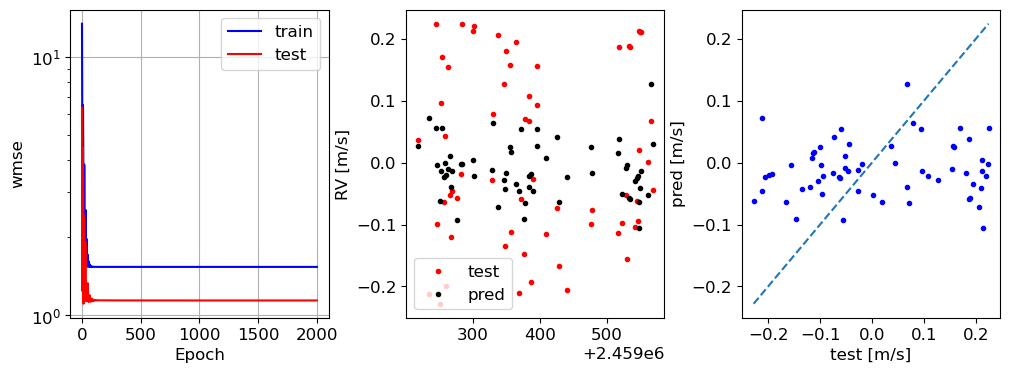

0.14521270777222386
2/2 [==============================] - 0s 2ms/step


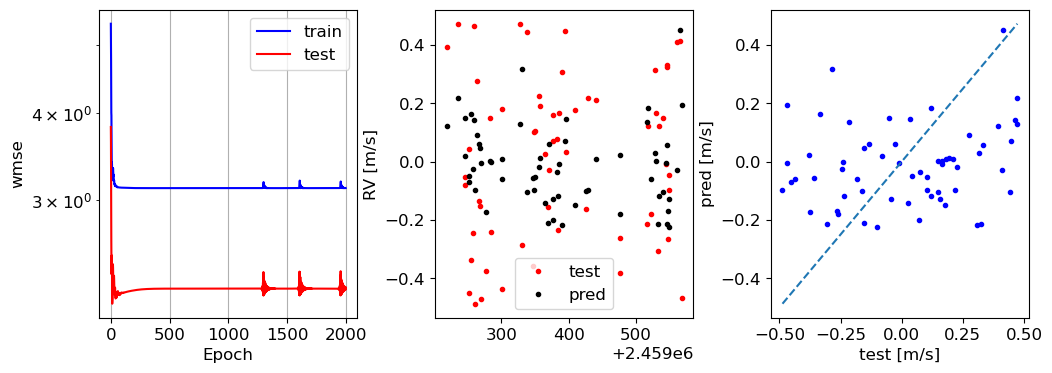

0.2932830143143765
2/2 [==============================] - 0s 2ms/step


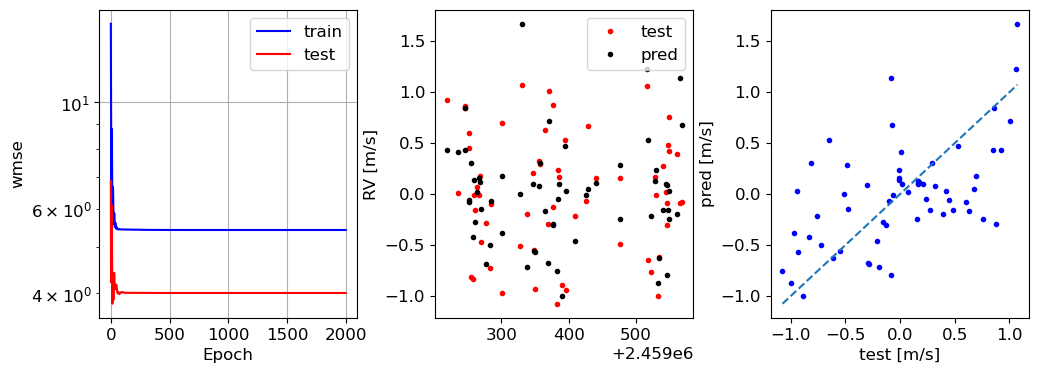

0.5203761070885768
2/2 [==============================] - 0s 1ms/step


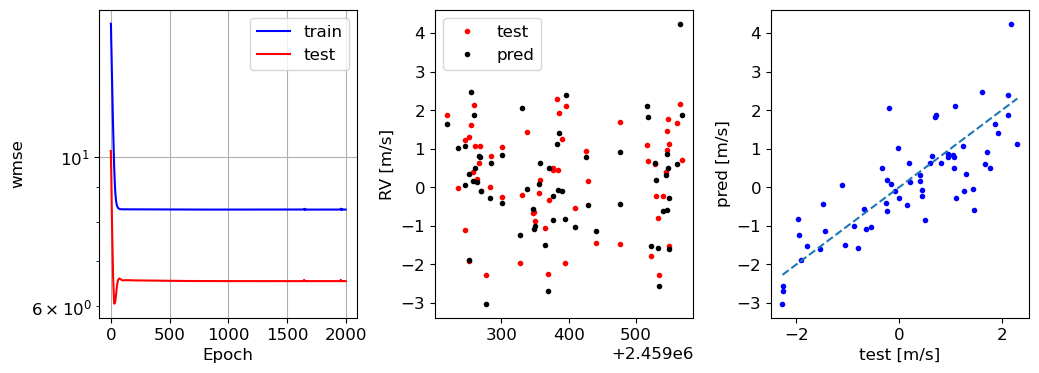

0.8124714848392429
2/2 [==============================] - 0s 2ms/step


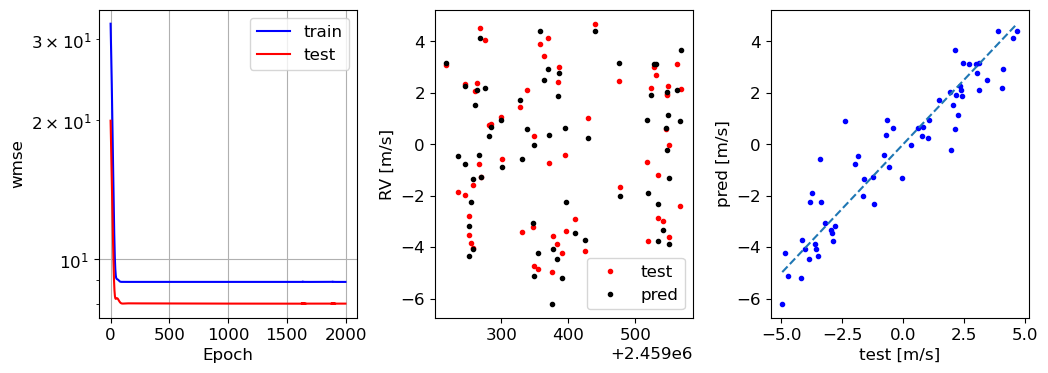

1.0120540400731133
2/2 [==============================] - 0s 1ms/step


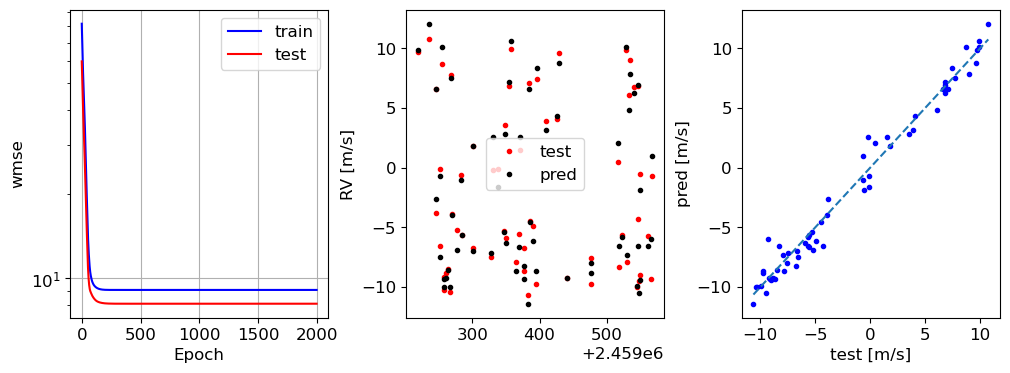

1.0193746830492516
2/2 [==============================] - 0s 2ms/step


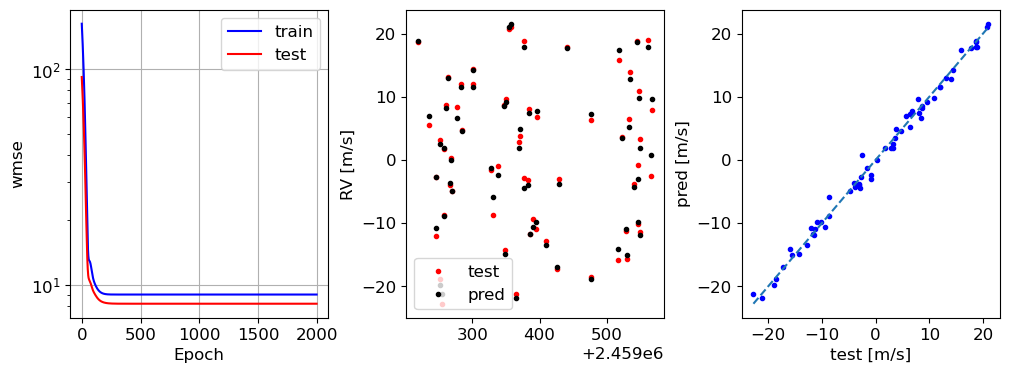

1.035136242610198
2/2 [==============================] - 0s 2ms/step


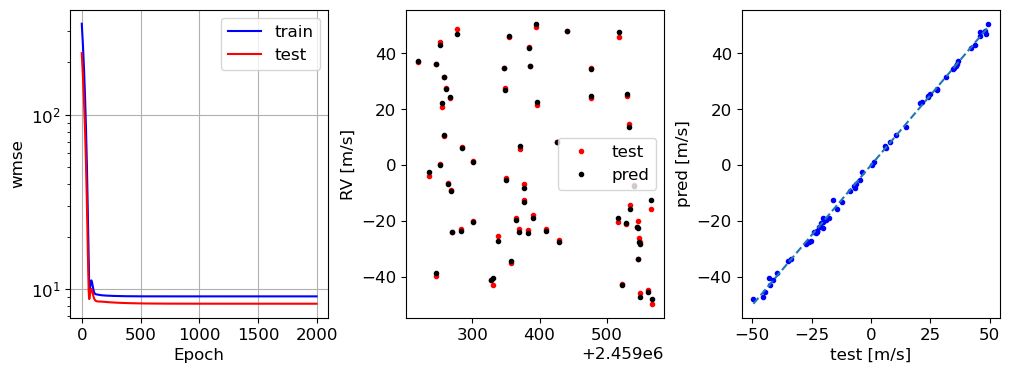

1.0361806015005175


In [20]:
# Add ramdom RV shift 
N = 10
rms_array_1 = np.zeros(N)
rms_array_2 = np.zeros(N)

for i in range(N):
    
    RV_inj = (np.random.random(202)-0.5)*amp[i]
    # X = (RV_FT_k[:5] + RV_inj).T
    X = np.vstack(((RV_FT_k[:5] + RV_inj), ΔRV_k[:5])).T
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    
    rms_array_1[i] = wmse(RV_inj, np.zeros(202), W)**0.5
    rms_array_2[i] = std
    

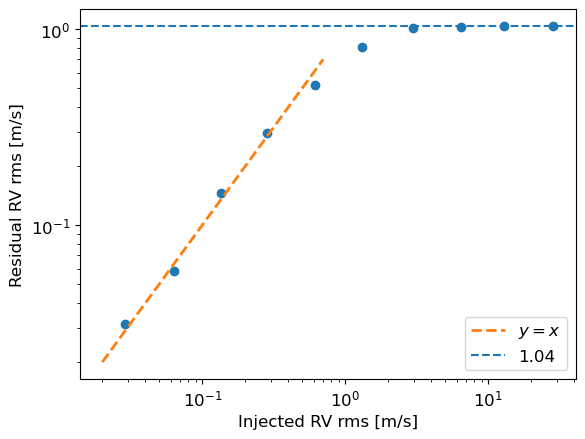

In [21]:
plt.plot(rms_array_1, rms_array_2, 'o')
plt.plot([0.02,0.7], [0.02,0.7], '--', lw=2, label='$y = x$')
plt.axhline(y=rms_array_2[-1], ls='--', label='%.2f' % rms_array_2[-1])
plt.xlabel('Injected RV rms [m/s]')
plt.ylabel('Residual RV rms [m/s]')
plt.xscale('log')
plt.yscale('log')
plt.legend()

2/2 [==============================] - 0s 2ms/step


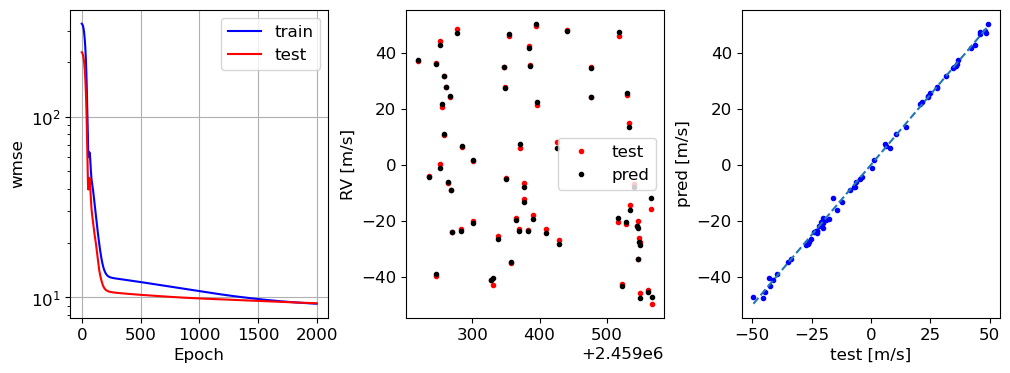

1.1348338363742694
2/2 [==============================] - 0s 3ms/step


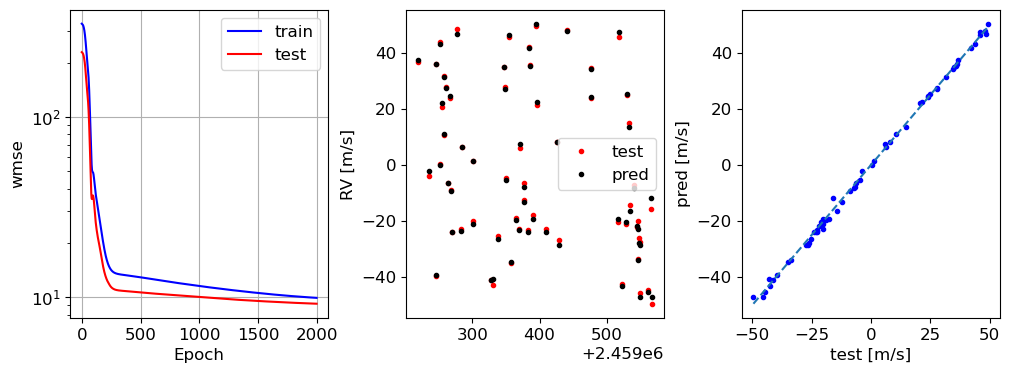

1.127098575084601


In [22]:
# Add ramdom RV shift 
weights = np.zeros((run, X.shape[0]))
for i in range(run):
    
    X = (RV_FT_k[:5] + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(4, kernel_initializer='uniform', activation=tf.nn.relu))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()
    

2/2 [==============================] - 0s 2ms/step


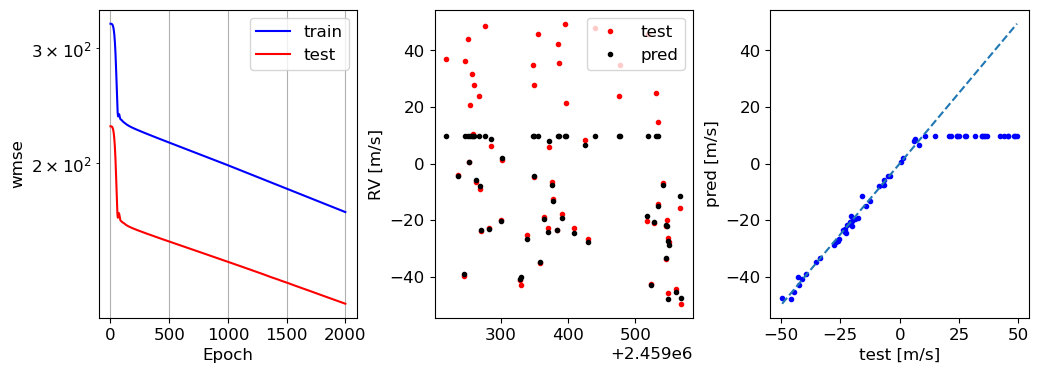

12.010206497939205
2/2 [==============================] - 0s 2ms/step


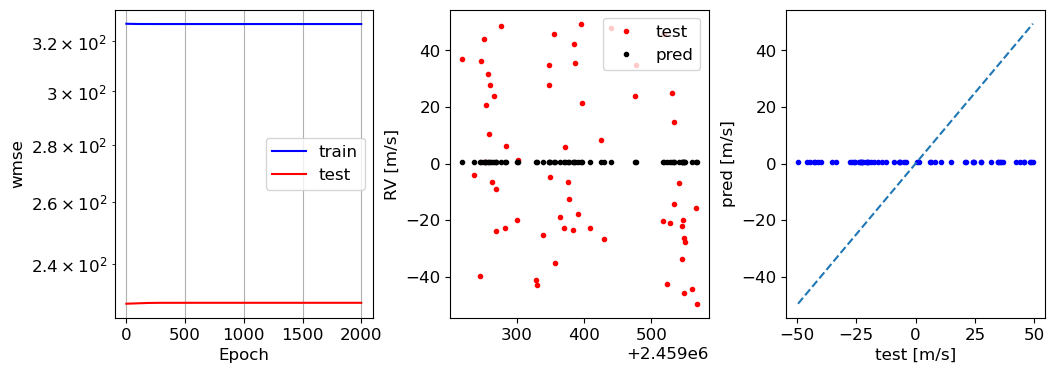

28.987742696402456


In [23]:
# Add ramdom RV shift 
weights = np.zeros((run, X.shape[0]))
for i in range(run):
    
    X = (RV_FT_k[:5] + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(4, kernel_initializer='uniform', activation=tf.nn.relu))
    lr_model.add(Dense(2, kernel_initializer='uniform', activation=tf.nn.relu))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()
    

2/2 [==============================] - 0s 2ms/step


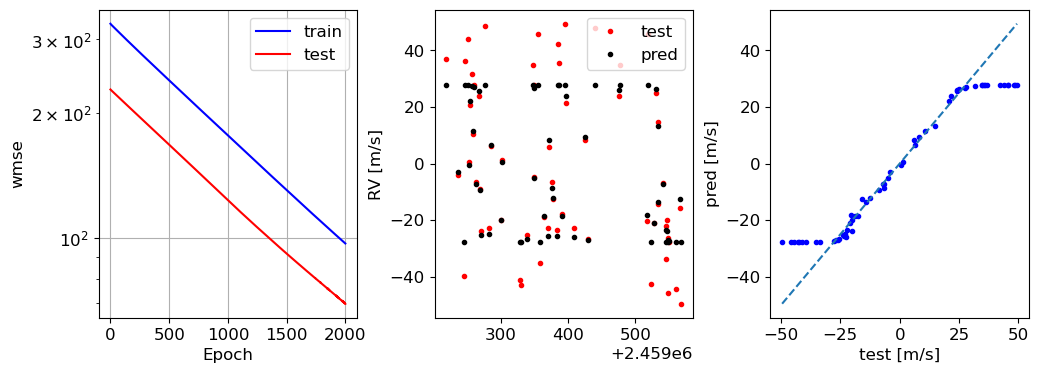

8.685625508264392


In [ ]:
# Add ramdom RV shift 
run = 2
weights = np.zeros((run, X.shape[0]))
for i in range(run):
    
    X = (RV_FT_k[:5] + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(4, kernel_initializer='uniform', activation=tf.nn.tanh))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()
    
    


In [ ]:
# Add ramdom RV shift 
weights = np.zeros((run, X.shape[0]))
for i in range(run):
    
    RV_inj = (np.random.random(202)-0.5)*5
    X = (RV_FT_k[:5] + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(4, kernel_initializer='uniform', activation=tf.nn.tanh))
    lr_model.add(Dense(2, kernel_initializer='uniform', activation=tf.nn.tanh))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()
    
    


In [ ]:
# Add ramdom RV shift 
weights = np.zeros((run, X.shape[0]))
for i in range(run):
    
    X = (RV_FT_k[:5] + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(4, kernel_initializer='uniform', activation=tf.nn.tanh))
    lr_model.add(Dense(2, kernel_initializer='uniform', activation=tf.nn.relu))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()
    

In [ ]:
# Add ramdom RV shift 
weights = np.zeros((run, X.shape[0]))
for i in range(run):
    
    X = (RV_FT_k[:5] + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(4, kernel_initializer='uniform', activation=tf.nn.relu))
    lr_model.add(Dense(2, kernel_initializer='uniform', activation=tf.nn.tanh))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()
    

In [ ]:
for i in range(run):
    
    X = (RV_FT_k[:5] + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(4, kernel_initializer='uniform', activation=tf.nn.relu))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.nn.relu))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()

In [ ]:
for i in range(run):
    
    X = (RV_FT_k[:5] + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(10, kernel_initializer='uniform', activation=tf.nn.relu))
    lr_model.add(Dense(5, kernel_initializer='uniform', activation=tf.nn.relu))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.nn.relu))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()

In [ ]:
from tensorflow.keras.layers import LeakyReLU

for i in range(run):
    
    X = (RV_FT_k[:5] + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(4, kernel_initializer='uniform', activation=LeakyReLU()))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=LeakyReLU()))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()

In [ ]:
from tensorflow.keras.layers import LeakyReLU

for i in range(run):
    
    X = (RV_FT_k[:5] + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(4, kernel_initializer='uniform', activation=LeakyReLU()))
    lr_model.add(Dense(2, kernel_initializer='uniform', activation=LeakyReLU()))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=LeakyReLU()))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()

# It works but not practical

In [ ]:
from tensorflow.keras.layers import LeakyReLU

for i in range(run):
    
    X = (np.vstack((ΔRV_k[:5], A_k[:5])) + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(4, kernel_initializer='uniform', activation=LeakyReLU()))
    lr_model.add(Dense(2, kernel_initializer='uniform', activation=LeakyReLU()))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=LeakyReLU()))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()

In [ ]:
from tensorflow.keras.layers import LeakyReLU

for i in range(run):
    
    X = (np.vstack((ΔRV_k[:5], A_k[:5])) + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(4, kernel_initializer='uniform', activation=LeakyReLU()))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=LeakyReLU()))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()

In [ ]:
from tensorflow.keras.layers import LeakyReLU

for i in range(run):
    
    X = (np.vstack((ΔRV_k[:5], A_k[:5])) + RV_inj).T    
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    



In [ ]:
from tensorflow.keras.layers import LeakyReLU

for i in range(run):
    
    X = (ΔRV_k[:5] + RV_inj).T
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()

In [ ]:
lr_model.get_weights()[0].flatten().sum()

In [ ]:
for i in range(run):
    
    X = np.vstack(( RV_FT_k[:5] + RV_inj, ΔRV_k[:5])).T 
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=4000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()

In [ ]:
lr_model.get_weights()[0].flatten()

In [ ]:
np.std(RV_inj)

In [ ]:
for i in range(run):
    
    X = np.vstack(( RV_FT_k[:5] + RV_inj, ΔRV_k[:5], rv_daily-np.mean(rv_daily)+RV_inj )).T 
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()

In [ ]:
for i in range(run):
    
    X = np.vstack(( RV_FT_k[:5] + RV_inj, ΔRV_k[:5], rv_daily-np.mean(rv_daily)+RV_inj )).T 
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(4, kernel_initializer='uniform', activation=tf.nn.tanh))
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()

In [ ]:
for i in range(1):
    
    X = np.vstack(( RV_FT_k[:5] + RV_inj, ΔRV_k[:5], A_k[:5], rv_daily-np.mean(rv_daily)+RV_inj )).T 
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=2000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()

In [ ]:
for i in range(1):
    
    X = np.vstack(( RV_FT_k[:5] + RV_inj, ΔRV_k[:5], A_k[:5], rv_daily-np.mean(rv_daily)+RV_inj )).T 
    Y = RV_inj

    ###################
    # build the model #
    ###################
    input_dim = X.shape[1]
    lr_model = Sequential()
    lr_model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.activations.linear))
    lr_model, y_test, y_pred, σrv_test, bjd_test, std  = model_MLP(X, Y, bjd_daily, σrv_daily, lr_model, epochs=5000, learning_rate=5e-3)
    # lr_model.get_weights()[0].flatten()